In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
# import EoN

In [3]:
def download_file(url):
    file_path = url.split('/')[-1]
    resp = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(resp.content)
    return file_path

# 1. Epidemias e marketing viral

## Tempo para propagação

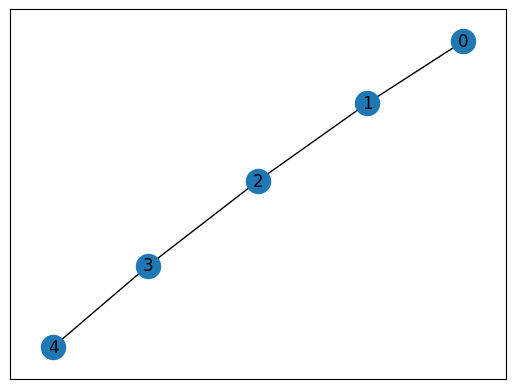

In [4]:
G = nx.path_graph(5)
nx.draw_networkx(G)

In [5]:
nx.eccentricity(G)

{0: 4, 1: 3, 2: 2, 3: 3, 4: 4}

O **centro** da rede indica os nós que propagam informações rapidamente:

In [6]:
nx.center(G)

[2]

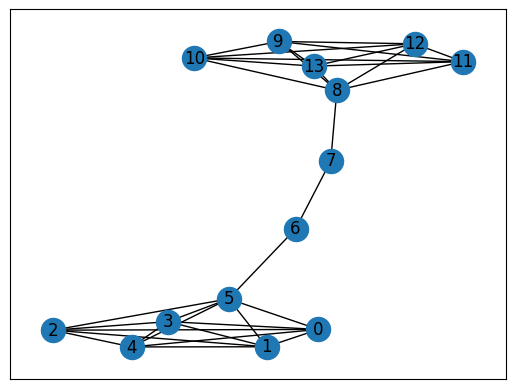

In [7]:
G = nx.barbell_graph(6, 2)
nx.draw_networkx(G)

In [8]:
nx.center(G)

[6, 7]

In [9]:
nx.eccentricity(G, 6)

3

## Modelo de epidemia
Biblioteca `EoN` (*Epidemics on Networks*)

https://epidemicsonnetworks.readthedocs.io/en/latest/EoN.html

In [10]:
pip install EoN --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
N = 10000
p = 0.01
G = nx.erdos_renyi_graph(N, p, seed=42)
print(G)

Graph with 10000 nodes and 498300 edges


### Parâmetros

In [12]:
tmax = 10
tau = 0.1  # transmission rate
gamma = 1.0  # recovery rate
rho = 0.005  # random fraction initially infected

### Modelo com imunidade

In [14]:
'''t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)

plt.plot(t, I)
plt.xlabel('Tempo')
plt.ylabel('Número de infectados');'''

"t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)\n\nplt.plot(t, I)\nplt.xlabel('Tempo')\nplt.ylabel('Número de infectados');"

### Modelo **sem** imunidade

In [15]:
'''t, S, I = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax=tmax)

plt.plot(t, I)
plt.xlabel('Tempo')
plt.ylabel('Número de infectados');'''

"t, S, I = EoN.fast_SIS(G, tau, gamma, rho=rho, tmax=tmax)\n\nplt.plot(t, I)\nplt.xlabel('Tempo')\nplt.ylabel('Número de infectados');"

# 2. Busca em redes

In [16]:
url = 'https://snap.stanford.edu/data/roadNet-PA.txt.gz'
file_path = download_file(url)
file_path

'roadNet-PA.txt.gz'

Lembrando que a rede é direcionada!

In [17]:
G = nx.read_edgelist(file_path, create_using=nx.DiGraph)
print(G)

DiGraph with 1088092 nodes and 3083796 edges


In [18]:
np.random.seed(42)
for src, dst in G.edges:
    G.edges[src, dst]['road_length'] = np.random.randint(1, 50)

## Busca sem pesos

Caminhos até os vizinhos:

In [19]:
G.adj['0']

AtlasView({'1': {'road_length': 39}, '6309': {'road_length': 29}, '6353': {'road_length': 15}})

In [20]:
nx.shortest_path(G, '0', '1')

['0', '1']

In [21]:
nx.shortest_path(G, '0', '6309')

['0', '6309']

In [22]:
nx.shortest_path(G, '0', '6353')

['0', '6353']

Para saber a distância:

In [23]:
nx.shortest_path_length(G, '0', '6353')

1

Caminhos de comprimento 2:

In [24]:
G.adj['6309']

AtlasView({'0': {'road_length': 8}, '6310': {'road_length': 21}, '6344': {'road_length': 39}})

In [25]:
nx.shortest_path(G, '0', '6310')

['0', '6309', '6310']

In [26]:
nx.shortest_path_length(G, '0', '6310')

2

Distâncias podem crescer rapidamente nessa rede:

In [27]:
nx.shortest_path(G, '0', '2')

['0',
 '6309',
 '6310',
 '6332',
 '7304',
 '3428',
 '3429',
 '2778',
 '2777',
 '2943',
 '3130',
 '3131',
 '3062',
 '3063',
 '3205',
 '3365',
 '3352',
 '3347',
 '3348',
 '3350',
 '2977',
 '4032',
 '4031',
 '4039',
 '4040',
 '4325',
 '4312',
 '4048',
 '4047',
 '4049',
 '4050',
 '4051',
 '4021',
 '4023',
 '4019',
 '4020',
 '4002',
 '4007',
 '4013',
 '4012',
 '4004',
 '4006',
 '388',
 '4',
 '2']

In [28]:
nx.shortest_path_length(G, '0', '2')

44

In [29]:
path = nx.shortest_path(G, '0', '2')
len(path) - 1

44

## Busca com pesos

In [30]:
nx.shortest_path(G, '0', '1', weight='road_length')

['0', '1']

In [31]:
nx.shortest_path_length(G, '0', '1', weight='road_length')

39

In [32]:
path_to_2 = nx.shortest_path(G, '0', '2', weight='road_length')
len(path_to_2)

48

In [33]:
nx.shortest_path_length(G, '0', '2', weight='road_length')

892

# 3. Falhas em redes

## Rede aleatória *Erdös-Rényi*

In [34]:
n = 5000
p = 0.005
G = nx.erdos_renyi_graph(n, p, seed=42)
print(G)

Graph with 5000 nodes and 62048 edges


No início, a rede está conectada:

In [35]:
nx.is_connected(G)

True

In [36]:
def attack(g, targeted, seed=None):
    np.random.seed(seed)  # Para fins didáticos, vamos fixar a semente
    num_removed = 0
    while nx.is_connected(g):
        if not targeted:  # Escolha totalmente aleatória
            node_to_remove = np.random.choice(g.nodes)
        else:  # Escolha proporcional ao grau
            degrees = [degree for node, degree in g.degree]
            degrees = np.array(degrees)
            prob = degrees / np.sum(degrees)  # Normalizando para somar 1
            node_to_remove = np.random.choice(g.nodes, p=prob)
        g.remove_node(node_to_remove)
        num_removed += 1
    print(f'Nós removidos até desconectar: {num_removed}')

In [37]:
H = G.copy()
attack(H, targeted=False, seed=42)

Nós removidos até desconectar: 3082


In [38]:
print(H)

Graph with 1918 nodes and 9202 edges


In [39]:
nx.is_connected(H)

False

In [40]:
H = G.copy()
attack(H, targeted=True, seed=42)

Nós removidos até desconectar: 2747


In [41]:
print(H)

Graph with 2253 nodes and 11368 edges


## Rede livre de escala *Barabási-Albert*

In [42]:
G = nx.barabasi_albert_graph(n, 2, seed=42)
print(G)

Graph with 5000 nodes and 9996 edges


In [43]:
nx.is_connected(G)

True

In [44]:
H = G.copy()
attack(H, targeted=False, seed=42)

Nós removidos até desconectar: 101


In [45]:
print(H)

Graph with 4899 nodes and 9585 edges


In [46]:
nx.is_connected(H)

False

In [47]:
H = G.copy()
attack(H, targeted=True, seed=42)

Nós removidos até desconectar: 33


In [48]:
print(H)

Graph with 4967 nodes and 9653 edges


In [49]:
H = G.copy()
attack(H, targeted=False, seed=1)

Nós removidos até desconectar: 58


In [50]:
H = G.copy()
attack(H, targeted=True, seed=1)

Nós removidos até desconectar: 7


# 4. Recomendação em redes

**Rede de colaboração**

- Artigos na área de astrofísica
- Publicados entre 1993 e 2003

[Link para o dataset](https://snap.stanford.edu/data/ca-AstroPh.html)

Referência:
- J. Leskovec, J. Kleinberg and C. Faloutsos. Graph Evolution: Densification and Shrinking Diameters. ACM Transactions on Knowledge Discovery from Data (ACM TKDD), 1(1), 2007.

In [51]:
url = 'https://snap.stanford.edu/data/ca-AstroPh.txt.gz'
file_path = download_file(url)
file_path

'ca-AstroPh.txt.gz'

In [52]:
G = nx.read_edgelist(file_path)
print(G)

Graph with 18772 nodes and 198110 edges


Algumas opções para prever relações:
1. `nx.common_neighbor_centrality()`
2. `nx.jaccard_coefficient`
3. `nx.adamic_adar_index`
4. `nx.preferential_attachment`

Nosso nó de exemplo:

In [53]:
target_node = '276'
G.degree[target_node]

31

In [54]:
pairs = [(target_node, '283')]
recommendation = nx.common_neighbor_centrality(G, pairs, alpha=1.0)
recommendation = list(recommendation)
recommendation

[('276', '283', 1)]

In [55]:
list(nx.non_neighbors(G, target_node))[:10]

['1662',
 '5089',
 '6058',
 '6229',
 '10639',
 '16442',
 '19325',
 '19834',
 '21937',
 '25452']

In [56]:
available_recs = [(target_node, n) for n in nx.non_neighbors(G, target_node)]

## Vizinhos em comum

In [57]:
recommendation = nx.common_neighbor_centrality(G, available_recs, alpha=1.0)
recommendation = pd.DataFrame(
    recommendation,
    columns=['source', 'destination', 'prediction']
)
recommendation.sort_values('prediction', ascending=False)

,source,destination,prediction
34,276,72391,4
39,276,78627,4
13,276,32432,3
37,276,77098,3
6256,276,15309,3
...,...,...,...
6549,276,93404,0
6550,276,95461,0
6551,276,96331,0
6552,276,96364,0


## Coeficiente de *Jaccard*

In [58]:
recommendation2 = nx.jaccard_coefficient(G, available_recs)
recommendation2 = pd.DataFrame(
    recommendation2,
    columns=['source', 'destination', 'prediction']
)
recommendation2.sort_values('prediction', ascending=False)

,source,destination,prediction
34,276,72391,0.117647
12704,276,3539,0.090909
8486,276,132043,0.073171
3303,276,124591,0.064516
1,276,5089,0.064516
...,...,...,...
6549,276,93404,0.000000
6550,276,95461,0.000000
6551,276,96331,0.000000
6552,276,96364,0.000000


## *Adamic-Adar*

In [59]:
recommendation3 = nx.adamic_adar_index(G, available_recs)
recommendation3 = pd.DataFrame(
    recommendation3,
    columns=['source', 'destination', 'prediction']
)
recommendation3.sort_values('prediction', ascending=False)

,source,destination,prediction
2140,276,120425,1.338287
34,276,72391,1.068811
39,276,78627,1.062724
12704,276,3539,0.993491
12694,276,10110,0.993491
...,...,...,...
6549,276,93404,0.000000
6550,276,95461,0.000000
6551,276,96331,0.000000
6552,276,96364,0.000000


## Conexão preferencial

In [60]:
recommendation4 = nx.preferential_attachment(G, available_recs)
recommendation4 = pd.DataFrame(
    recommendation4,
    columns=['source', 'destination', 'prediction']
)
recommendation4.sort_values('prediction', ascending=False)

,source,destination,prediction
315,276,53213,15624
288,276,35290,13237
293,276,38109,13020
2284,276,62821,12958
2115,276,93504,11997
...,...,...,...
17578,276,87910,31
17577,276,117290,31
17576,276,95148,31
5242,276,95880,31


In [61]:
G.degree['53213'], G.degree['35290']

(504, 427)

## Exercícios

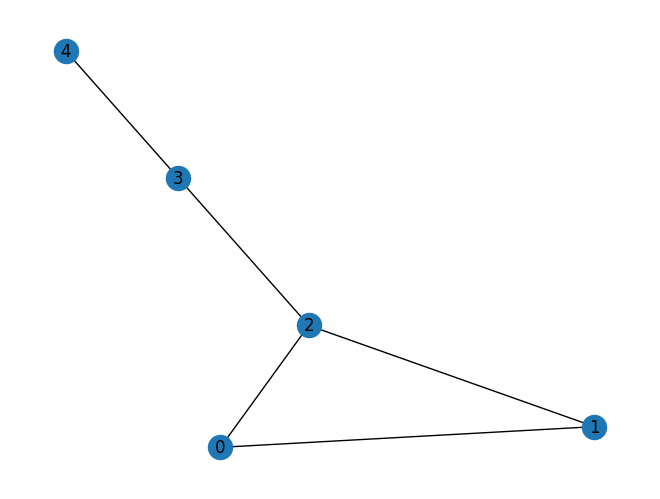

In [65]:
N = 5
E = {(0, 1), (1, 2), (2, 0), (2, 3), (3, 4)}

G = nx.Graph()
G.add_edges_from(E)
G.add_nodes_from(range(N))

nx.draw(G, with_labels=True)